In [206]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

**Cancer Dataset**

In this project, I am employing two different models: CNN and RNN (LSTM), to analyze descriptions provided by doctors related to three different types of cancer.

Overall, the dataset contains 7000 entries. However, I have chosen to work with only 4000 entries to expedite the training process.

The final conclusions are as follows:

    Accuracy for CNN: 99%
    Accuracy for LSTM: 95%

It's evident that the CNN model outperforms LSTM in text predictions.

In [207]:
df = pd.read_csv('/kaggle/input/biomedical-text-publication-classification/alldata_1_for_kaggle.csv', header = None, encoding='latin1')

df.head()


,0,1,2
0,NaN,0,a
1,0.0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,1.0,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,2.0,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,3.0,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [208]:
df = df[[1,2]]

In [209]:
df.head()

,1,2
0,0,a
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [210]:
df.columns=['labels','text']

In [211]:
df.head()

,labels,text
0,0,a
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [212]:
df.isnull().sum()

labels    0
text      0
dtype: int64

In [213]:
# Checking the length of the data set
print(len(df))

7571


In [214]:
# Reducing the size of the dataset, selecting only 10k
df = df.sample(4000)

In [215]:
df.sample(10)

,labels,text
1266,Colon_Cancer,netosis is a type of regulated cell death depe...
2499,Thyroid_Cancer,Scars Burns HealingVolume  10117720595131...
6098,Thyroid_Cancer,"""diagnostic performance of intravoxel incohere..."
5434,Lung_Cancer,"""tumor motion was well correlated with diaphra..."
7528,Colon_Cancer,""" preproof 0c highlights f0b7 propolis..."
1032,Thyroid_Cancer,"""Despite the biological link between thyroid h..."
5826,Colon_Cancer,""" patients who have undergone radical cystect..."
6334,Thyroid_Cancer,"""preadipocytes diï¬erentiate into adipocytes D..."
364,Colon_Cancer,""" the cell proliferative markers are very imp..."
176,Thyroid_Cancer,"""primary bone tumors in early adolescence with..."


In [216]:
df['targets'] = df['labels'].astype('category').cat.codes

In [217]:
df.sample(10)

,labels,text,targets
5253,Lung_Cancer,"""Methods Tissue collection We obtained 113 pai...",1
6960,Lung_Cancer,"""or paclitaxel (200 mg/m2)/carboplatin (area u...",1
6832,Lung_Cancer,"""These results suggest that there may be lifel...",1
7248,Thyroid_Cancer,IFNBased Biotherapeutics toHarness the Host Ag...,2
1025,Thyroid_Cancer,"""attention has been paid to whether snoring fr...",2
6123,Thyroid_Cancer,Hepatocellular carcinoma HCC is a high mortali...,2
4998,Colon_Cancer,microbiota involves communities ofhepatitis is...,0
6223,Thyroid_Cancer,significant genebiomarkers of primary colorect...,2
4206,Thyroid_Cancer,Neurosteroids Biosynthesisand Physiological Fu...,2
5416,Lung_Cancer,"""versus gemcitabine/carboplatin in advanced no...",1


In [218]:
df['labels'].value_counts()

labels
Thyroid_Cancer    1466
Colon_Cancer      1377
Lung_Cancer       1157
Name: count, dtype: int64

In [219]:
# Number of classes
K = df['targets'].max() + 1
K

3

In [220]:
from sklearn.model_selection import train_test_split

random_seed = 42

df_train, df_test = train_test_split(df, test_size=0.3, random_state=random_seed)

In [221]:
# Convert sentences to sequences - keeps 2000 most frequent and discard the rest.
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Builds the vocabulary based on the most common words. It assigns a unique integer to each word based on its frequency
tokenizer.fit_on_texts(df_train['text'])

# Each word in the sentences is replaced by its corresponding integer based on the vocabulary created by the tokenizer.
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [222]:
# get total unique words mapped by tokenizer (True size of our unique words)
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found unique words: {V}')

Found unique words: 202293


In [223]:
# pad sequences so we get a N x T matrix - all the text must have same dimension size
data_train = pad_sequences(sequences_train)
print(f'Shape of data train tensor: {data_train.shape}')

Shape of data train tensor: (2800, 4276)


In [224]:
data_train

array([[   0,    0,    0, ...,   73,  175,    6],
       [   0,    0,    0, ...,   63,    8,  214],
       [   0,    0,    0, ...,  742,  150,    3],
       ...,
       [   0,    0,    0, ...,    9,  458,   12],
       [   0,    0,    0, ...,   66,   11,   12],
       [   0,    0,    0, ...,    4,  399, 1066]], dtype=int32)

In [225]:
# Get sequences length
T = data_train.shape[1]
T

4276

In [226]:
data_test = pad_sequences(sequences_test, maxlen=T)
print(f'Shape of data test tensor: {data_test.shape}')

Shape of data test tensor: (1200, 4276)


In [227]:
# Creating the CNN model

# Choosing embedding dimensionality
D = 30

i = Input(shape=(T,))
x = Embedding(V+ 1 ,D)(i)
x = Conv1D(32,2, strides=1 ,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64,3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x) # where K is the total of news's labels

model = Model(i,x)

In [228]:
# Compile and Fit the model
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

print('Training the model...')
r = model.fit(
    data_train,
    df_train['targets'],
    epochs = 20,
    validation_data=(data_test, df_test['targets'])
)

Training the model...
Epoch 1/20
88/88 [==============================] - 14s 147ms/step - loss: 1.0237 - accuracy: 0.4711 - val_loss: 0.8249 - val_accuracy: 0.7308
Epoch 2/20
88/88 [==============================] - 12s 139ms/step - loss: 0.4622 - accuracy: 0.8236 - val_loss: 0.3436 - val_accuracy: 0.8333
Epoch 3/20
88/88 [==============================] - 12s 141ms/step - loss: 0.2164 - accuracy: 0.9125 - val_loss: 0.1501 - val_accuracy: 0.9533
Epoch 4/20
88/88 [==============================] - 12s 139ms/step - loss: 0.1048 - accuracy: 0.9707 - val_loss: 0.0874 - val_accuracy: 0.9733
Epoch 5/20
88/88 [==============================] - 12s 137ms/step - loss: 0.0549 - accuracy: 0.9864 - val_loss: 0.0555 - val_accuracy: 0.9900
Epoch 6/20
88/88 [==============================] - 13s 144ms/step - loss: 0.0343 - accuracy: 0.9946 - val_loss: 0.0374 - val_accuracy: 0.9942
Epoch 7/20
88/88 [==============================] - 12s 139ms/step - loss: 0.0269 - accuracy: 0.9936 - val_loss: 0.0229 

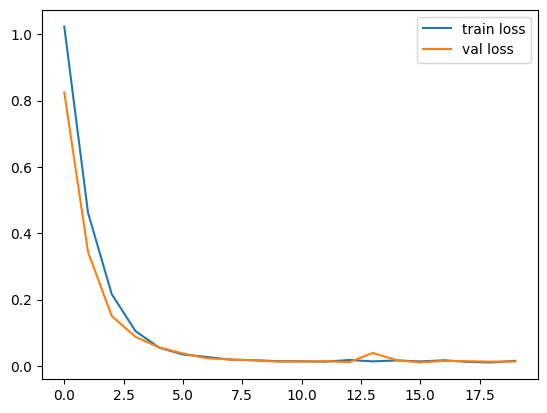

In [229]:
# Checking loss per itartion
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

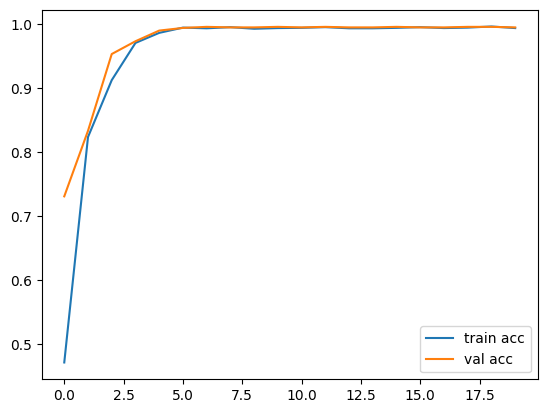

In [230]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [231]:

from sklearn.metrics import classification_report


predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)  # Convert logits to class labels

# Get true labels
y_true = df_test['targets']

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)




38/38 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       416
           1       1.00      0.99      1.00       361
           2       1.00      1.00      1.00       423

    accuracy                           0.99      1200
   macro avg       1.00      0.99      1.00      1200
weighted avg       1.00      0.99      1.00      1200



In [232]:
classes = df['targets'].unique()

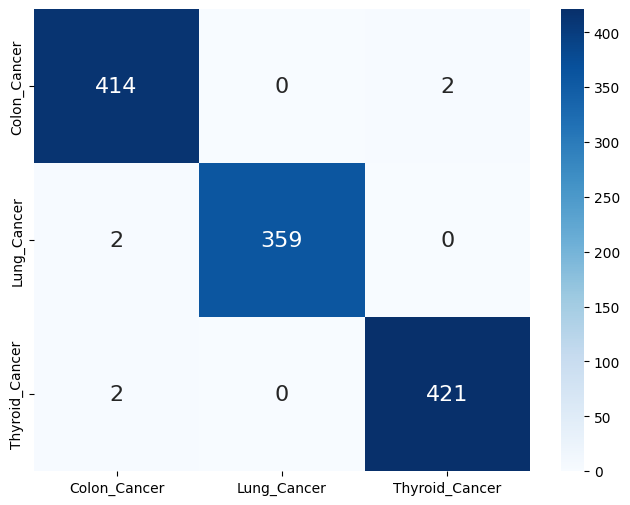

In [233]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'
    
}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])

plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')

plt.show()

In [234]:
# Creating the model for RNN (LSTM)

i = Input(shape=(T,)) # T = Sequence Length
x = Embedding(V+1,D)(i) # symbolic representation of the input data that will be passed through the layers of the neural network
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(K)(x)

model = Model(i,x)



In [235]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')

r_rnn = model.fit(
  data_train,
  df_train['targets'],
  epochs=20,
  validation_data=(data_test, df_test['targets'])
)

Training model...
Epoch 1/20
88/88 [==============================] - 306s 3s/step - loss: 0.9890 - accuracy: 0.4354 - val_loss: 0.7975 - val_accuracy: 0.6042
Epoch 2/20
88/88 [==============================] - 302s 3s/step - loss: 0.7026 - accuracy: 0.6529 - val_loss: 0.5789 - val_accuracy: 0.6775
Epoch 3/20
88/88 [==============================] - 301s 3s/step - loss: 0.5275 - accuracy: 0.7650 - val_loss: 0.4890 - val_accuracy: 0.8250
Epoch 4/20
88/88 [==============================] - 302s 3s/step - loss: 0.4250 - accuracy: 0.8761 - val_loss: 0.3807 - val_accuracy: 0.8758
Epoch 5/20
88/88 [==============================] - 302s 3s/step - loss: 0.3432 - accuracy: 0.8939 - val_loss: 0.3274 - val_accuracy: 0.8742
Epoch 6/20
88/88 [==============================] - 302s 3s/step - loss: 0.2788 - accuracy: 0.9082 - val_loss: 0.2739 - val_accuracy: 0.9008
Epoch 7/20
88/88 [==============================] - 307s 3s/step - loss: 0.2201 - accuracy: 0.9339 - val_loss: 0.2248 - val_accuracy: 0.

In [236]:
predictions = model.predict(data_test)
y_pred = np.argmax(predictions, axis=1)  # Convert logits to class labels

# Get true labels
y_true = df_test['targets']

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)

38/38 [==============================] - 14s 352ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       416
           1       1.00      0.95      0.97       361
           2       0.93      0.96      0.95       423

    accuracy                           0.95      1200
   macro avg       0.96      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



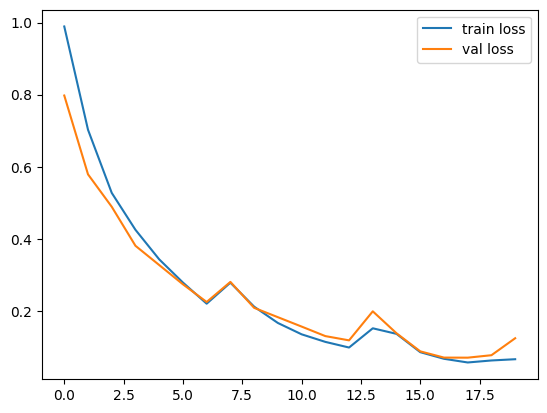

In [237]:
# Checking loss per itartion
plt.plot(r_rnn.history['loss'], label='train loss')
plt.plot(r_rnn.history['val_loss'], label='val loss')
plt.legend();

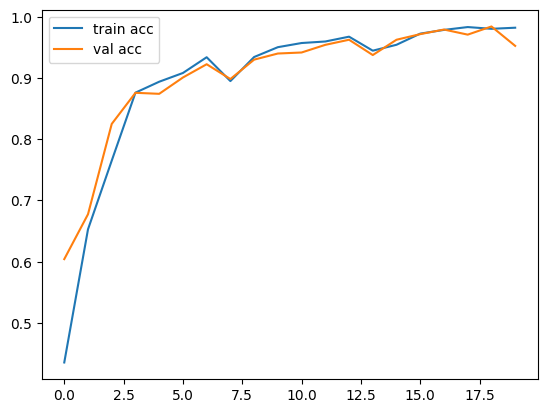

In [238]:
# Plot accuracy per iteration
plt.plot(r_rnn.history['accuracy'], label='train acc')
plt.plot(r_rnn.history['val_accuracy'], label='val acc')
plt.legend();

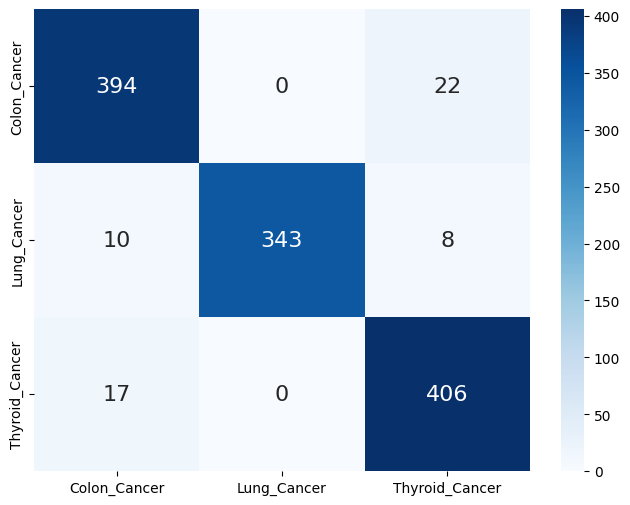

In [239]:
label_mapping = {
    0: 'Colon_Cancer',
    1: 'Lung_Cancer',
    2: 'Thyroid_Cancer'
    
}
marks = np.arange(len(label_mapping))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=[label_mapping[i] for i in label_mapping] , columns = [label_mapping[i] for i in label_mapping])

plt.figure(figsize=(8, 6))
plt.xlabel('Predicted')
plt.ylabel('True')
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d', cmap='Blues')

plt.show()